In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal import welch, find_peaks

In [56]:
color_map = {
    0: "red",
    1: "green",
    2: "blue",
}

## Functions

In [57]:
def load_data(filename):
    arr = np.load(filename)
    print(f"{filename} shape:{arr.shape}")
    return arr

In [58]:
def plot_pixel_change_matrix(data):
    """
    Plot ROI_H x ROI_W heatmaps (one per color channel) where
    darker pixels indicate larger temporal change over frames.

    data: numpy array of shape (num_frames, ROI_H, ROI_W, colors)
    """

    num_frames, ROI_H, ROI_W, colors = data.shape

    # Compute per-pixel temporal variation
    # Here: standard deviation across frames for each pixel & color
    change_map = np.std(data, axis=0)   # shape → (ROI_H, ROI_W, colors)

    # Normalize each color channel independently (0 = highest change → dark)
    norm_change = np.zeros_like(change_map)
    for c in range(colors):
        ch = change_map[:, :, c]
        ch_min, ch_max = ch.min(), ch.max()
        norm_change[:, :, c] = (ch - ch_min) / (ch_max - ch_min + 1e-9)

    # Plot each channel
    fig, axs = plt.subplots(1, colors, figsize=(5 * colors, 5))
    if colors == 1:
        axs = [axs]

    for c in range(colors):
        axs[c].imshow(1 - norm_change[:, :, c], cmap='grey')
        axs[c].set_title(f"Color channel {color_map[c]}")
        axs[c].axis("off")

    plt.tight_layout()
    plt.show()

In [59]:
def plot_aggregated_psd_rgb(arr, fs=12.5, red_ch=0, green_ch=1, blue_ch=2):
    """
    Compute and plot aggregated PSD separately for Red, Green, and Blue channels.

    This function sums the PSD of every pixel in the ROI/Image to show the
    total spectral energy per channel.

    arr: shape (num_frames, H, W, num_channels)
    """

    num_frames, H, W, C = arr.shape

    # Configuration for the 3 channels
    channels_config = [
        {'idx': red_ch, 'name': 'Red', 'color': 'red'},
        {'idx': green_ch, 'name': 'Green', 'color': 'green'},
        {'idx': blue_ch, 'name': 'Blue', 'color': 'blue'}
    ]

    plt.figure(figsize=(12, 6))

    # --- Process each channel ---
    for config in channels_config:
        ch_idx = config['idx']
        name = config['name']
        col = config['color']

        # 1. Extract Data
        # Flatten H and W dimensions: (Frames, H, W) -> (Frames, Pixels)
        # This allows us to calculate Welch on all pixels at once (Vectorization)
        channel_data = arr[:, :, :, ch_idx].reshape(num_frames, -1)

        # 2. Compute PSD (Vectorized)
        # axis=0 ensures we calculate PSD along the time dimension
        freqs, psd_all_pixels = welch(channel_data, fs=fs,
                                      nperseg=min(256, num_frames),
                                      axis=0)

        # 3. Aggregate (Sum) PSDs across all pixels (axis 1)
        agg_psd = np.sum(psd_all_pixels, axis=1)

        # 4. Peak Detection
        # Threshold: 5% of the max peak for this specific channel
        peaks, _ = find_peaks(agg_psd, height=np.max(agg_psd) * 0.05, distance=3)

        # 5. Plotting
        plt.plot(freqs, agg_psd, color=col, label=f"{name} Aggregated PSD", lw=2, alpha=0.8)
        plt.scatter(freqs[peaks], agg_psd[peaks], color=col, s=40, zorder=5)

        # 6. Annotations
        for idx in peaks:
            freq_val = freqs[idx]
            psd_val = agg_psd[idx]

            # Offset text slightly differently for each color to avoid overlap
            # Red high, Green mid, Blue low (just a visual heuristic)
            offset_mult = 1.05 + (ch_idx * 0.03)

            plt.annotate(f"{freq_val:.2f} Hz",
                         xy=(freq_val, psd_val),
                         xytext=(freq_val, psd_val * offset_mult),
                         color=col,
                         fontsize=9,
                         fontweight='bold',
                         arrowprops=dict(arrowstyle="->", lw=0.7, color=col))

    # --- Final Formatting ---
    plt.title(f"Aggregated PSD — RGB Channels (Summed over {H}x{W} pixels)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Summed Power Spectral Density")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Repeated Measures (Table)

In [60]:
data_1 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_212823.npy")
data_2 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213257.npy")
data_3 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213321.npy")

../04_2_pc_receive/frames_rg_888_160w-120h_20251204_212823.npy shape:(99, 120, 160, 3)
../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213257.npy shape:(99, 120, 160, 3)
../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213321.npy shape:(99, 120, 160, 3)


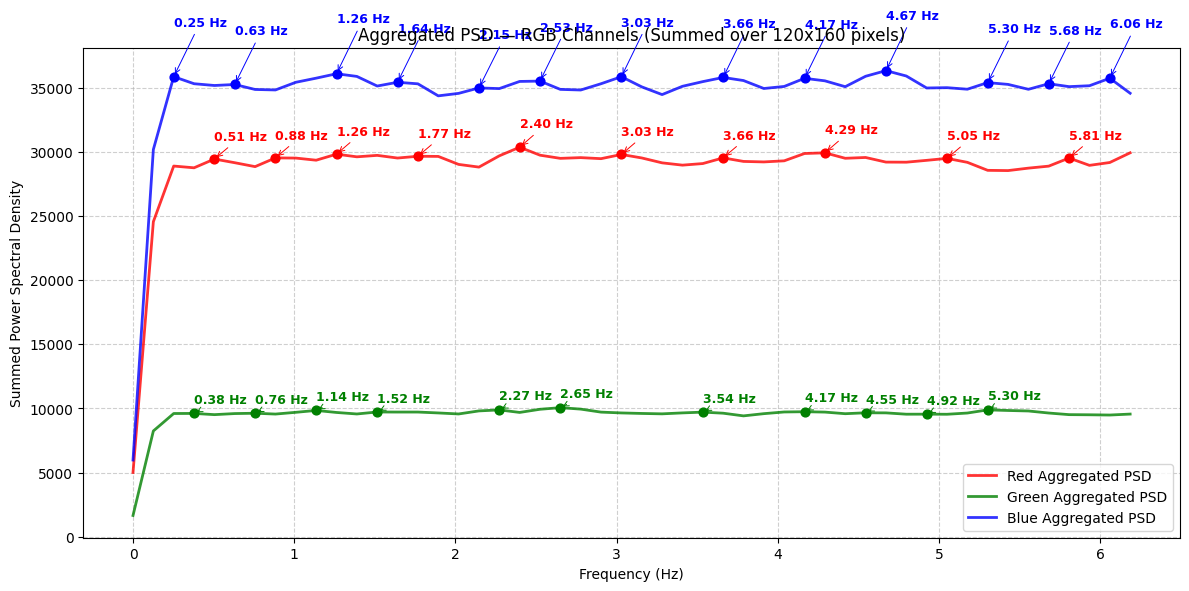

In [61]:
plot_aggregated_psd_rgb(data_1)

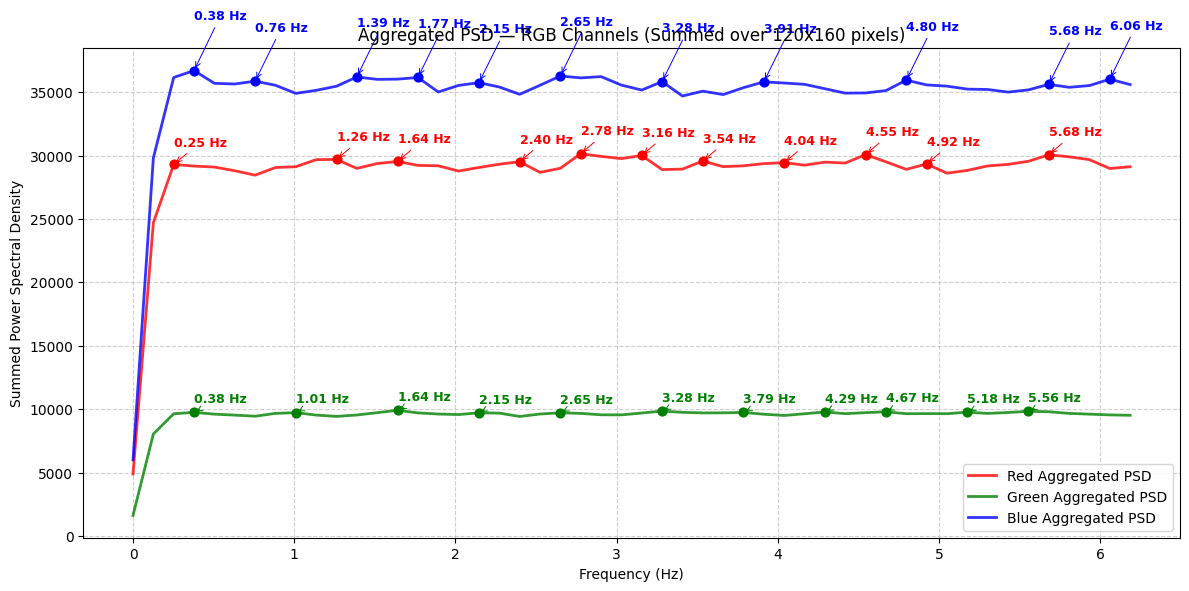

In [62]:
plot_aggregated_psd_rgb(data_2)

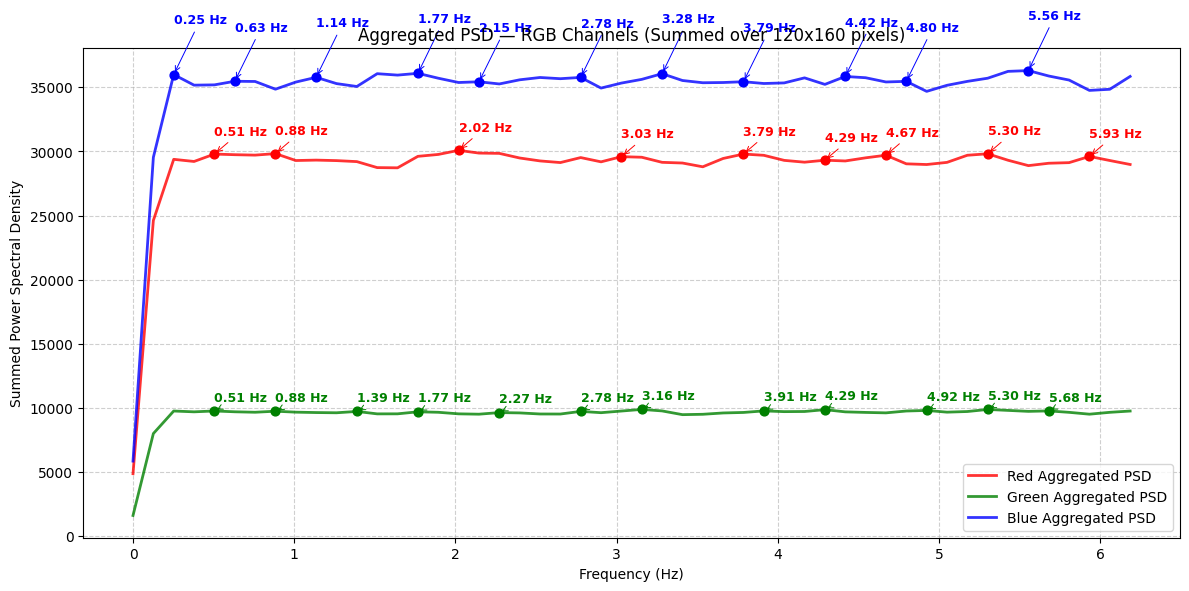

In [63]:
plot_aggregated_psd_rgb(data_3)

## Repeated measures (Hand)

In [64]:
data_1 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213920.npy")
data_2 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213950.npy")
data_3 = load_data("../04_2_pc_receive/frames_rg_888_160w-120h_20251204_214013.npy")

../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213920.npy shape:(99, 120, 160, 3)
../04_2_pc_receive/frames_rg_888_160w-120h_20251204_213950.npy shape:(99, 120, 160, 3)
../04_2_pc_receive/frames_rg_888_160w-120h_20251204_214013.npy shape:(99, 120, 160, 3)


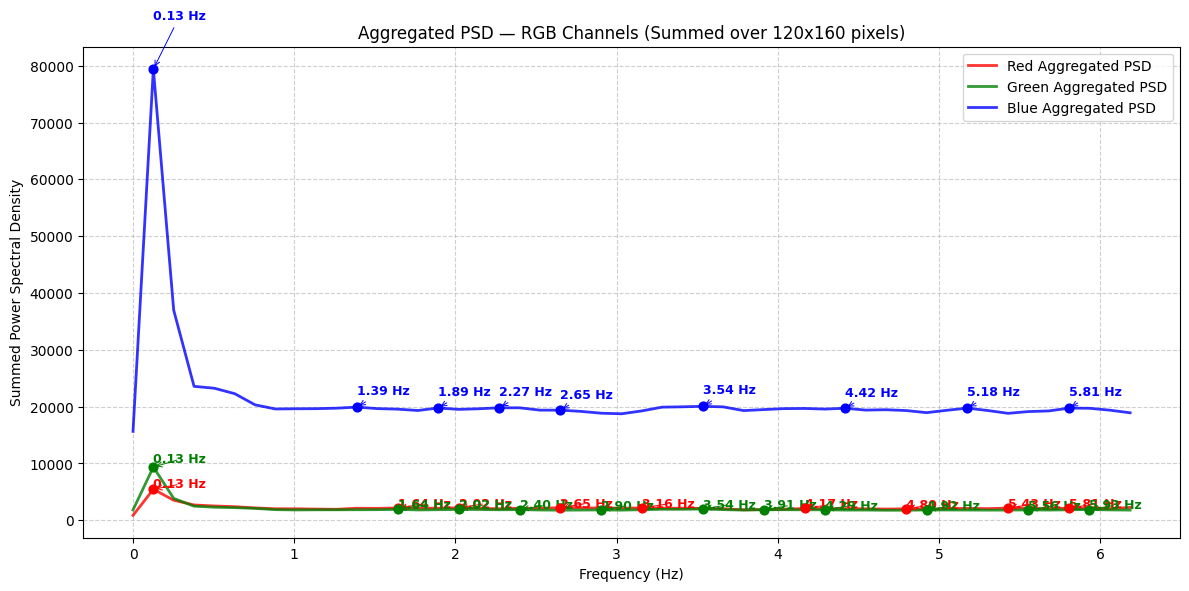

In [65]:
plot_aggregated_psd_rgb(data_1)

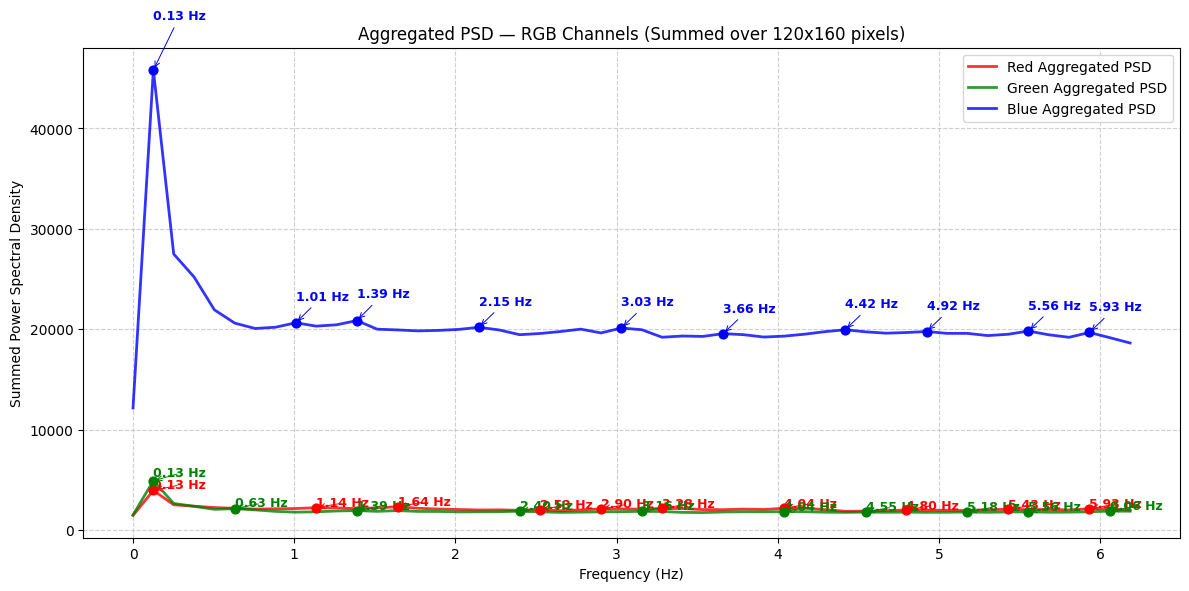

In [66]:
plot_aggregated_psd_rgb(data_2)

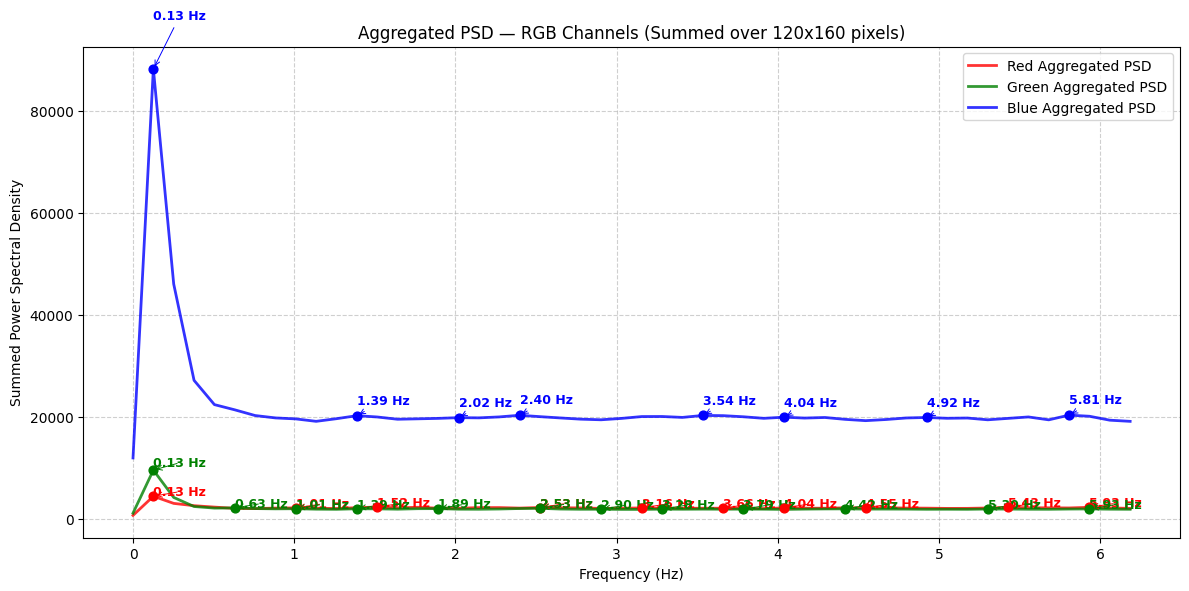

In [67]:
plot_aggregated_psd_rgb(data_3)

## Repeated Measures 64x64 (Table)

In [68]:
data_1 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221238.npy")
data_2 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221321.npy")
data_3 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221401.npy")

../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221238.npy shape:(350, 64, 64, 3)
../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221321.npy shape:(350, 64, 64, 3)
../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221401.npy shape:(350, 64, 64, 3)


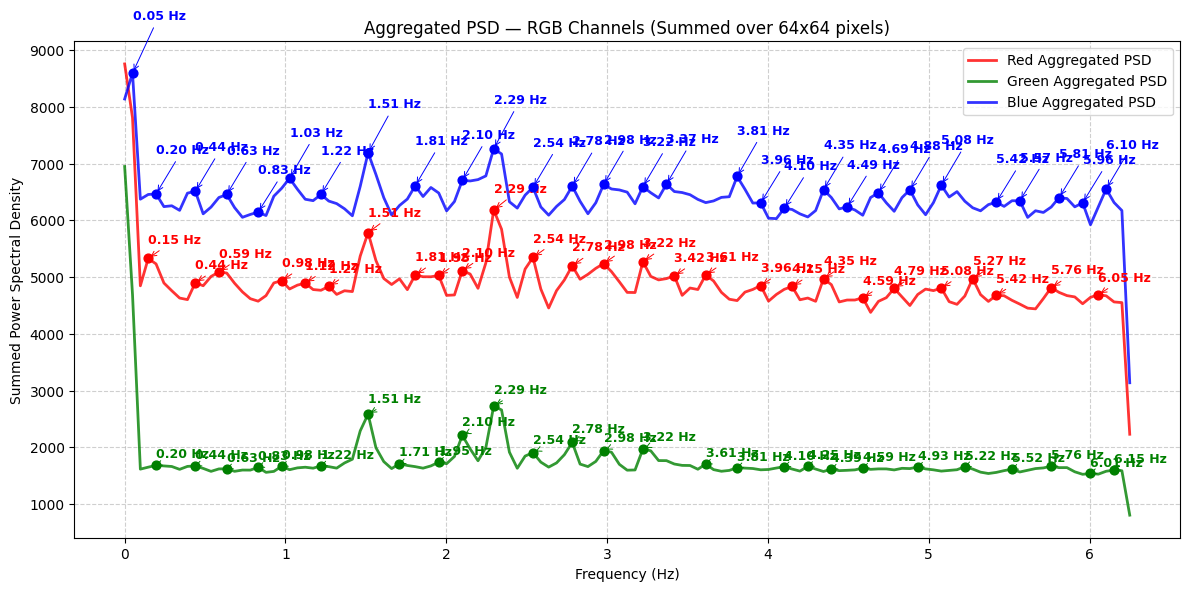

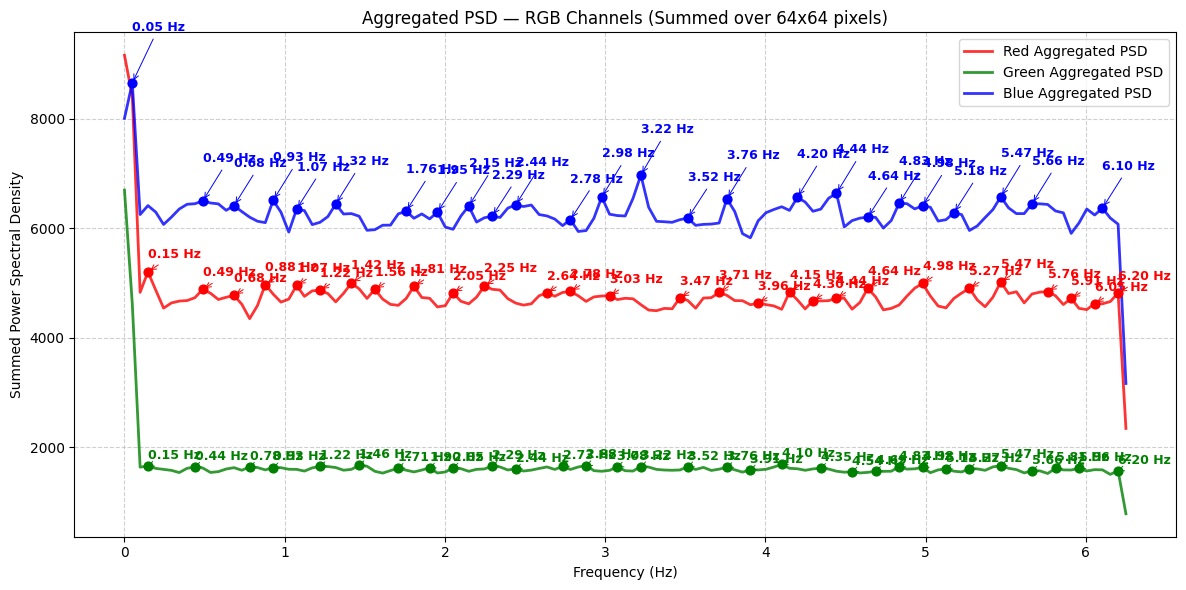

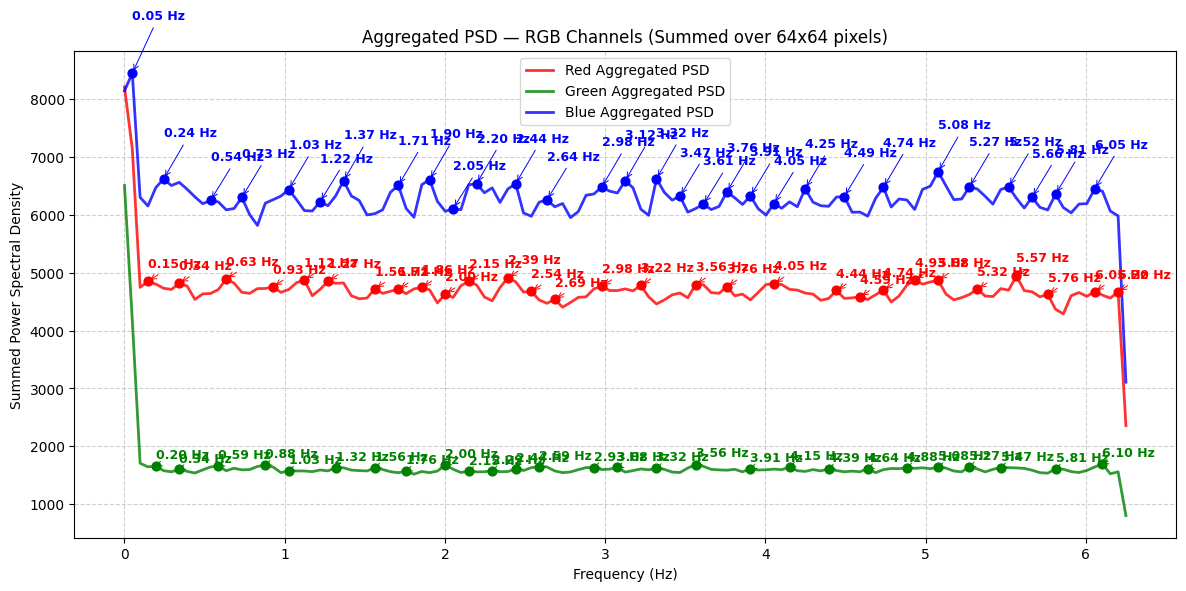

In [69]:
plot_aggregated_psd_rgb(data_1)
plot_aggregated_psd_rgb(data_2)
plot_aggregated_psd_rgb(data_3)

## Repeated Measures 64x64 (Hand)

In [70]:
data_1 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221821.npy")
data_2 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221857.npy")
data_3 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221934.npy")

../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221821.npy shape:(350, 64, 64, 3)
../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221857.npy shape:(350, 64, 64, 3)
../04_2_pc_receive/frames_rg_888_64w-64h_20251204_221934.npy shape:(350, 64, 64, 3)


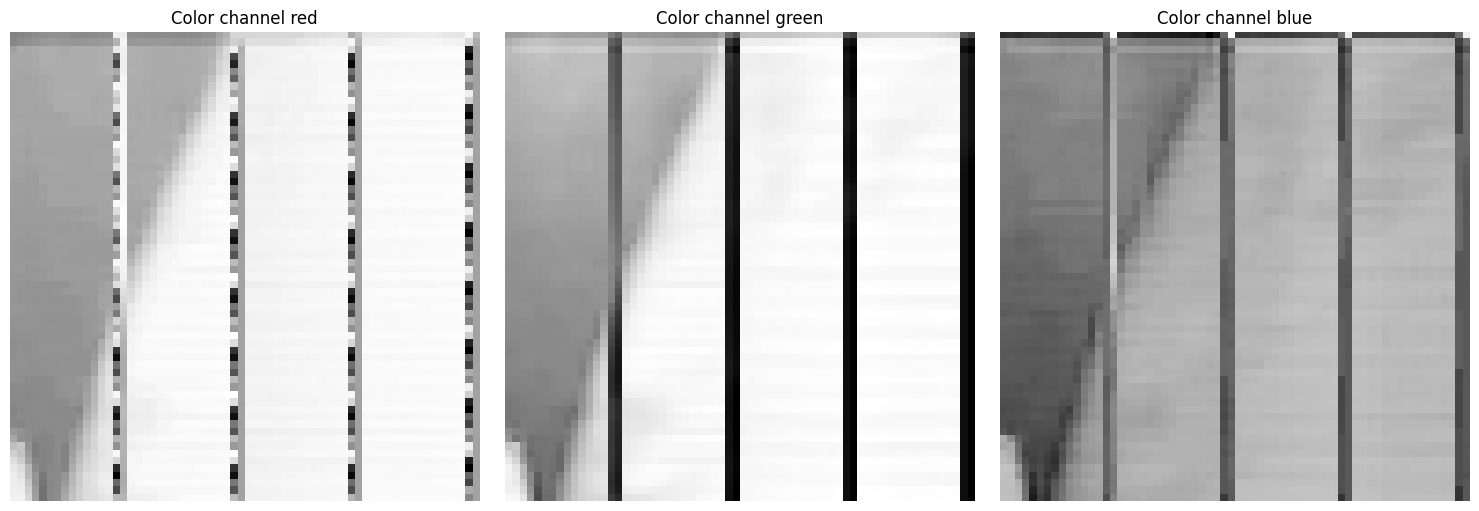

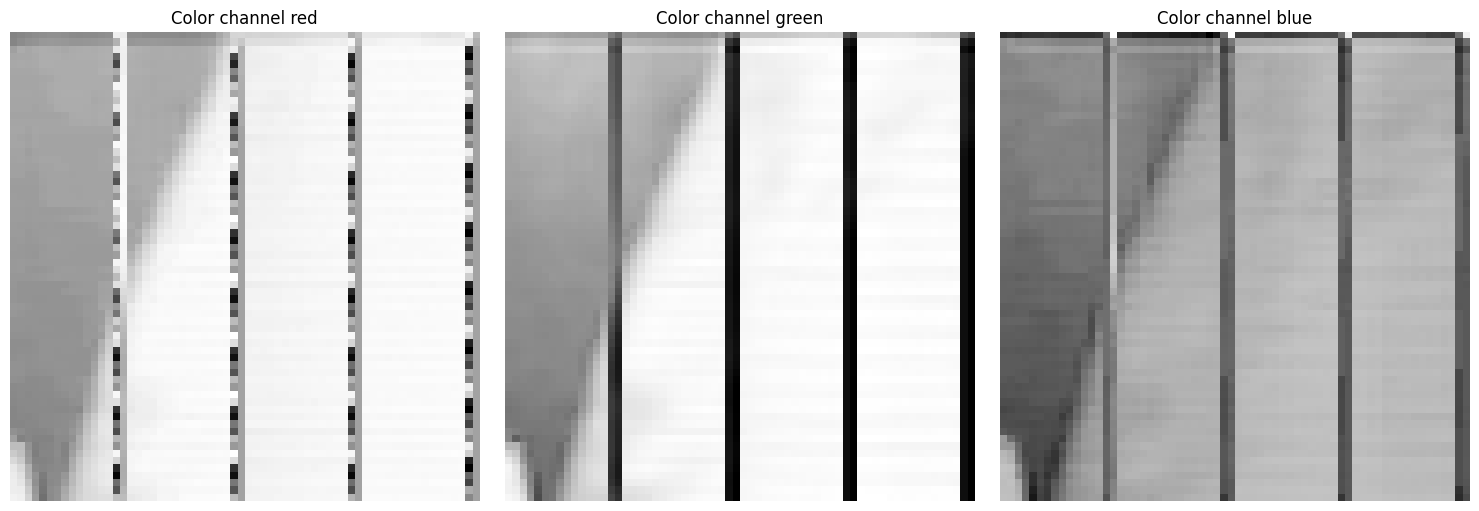

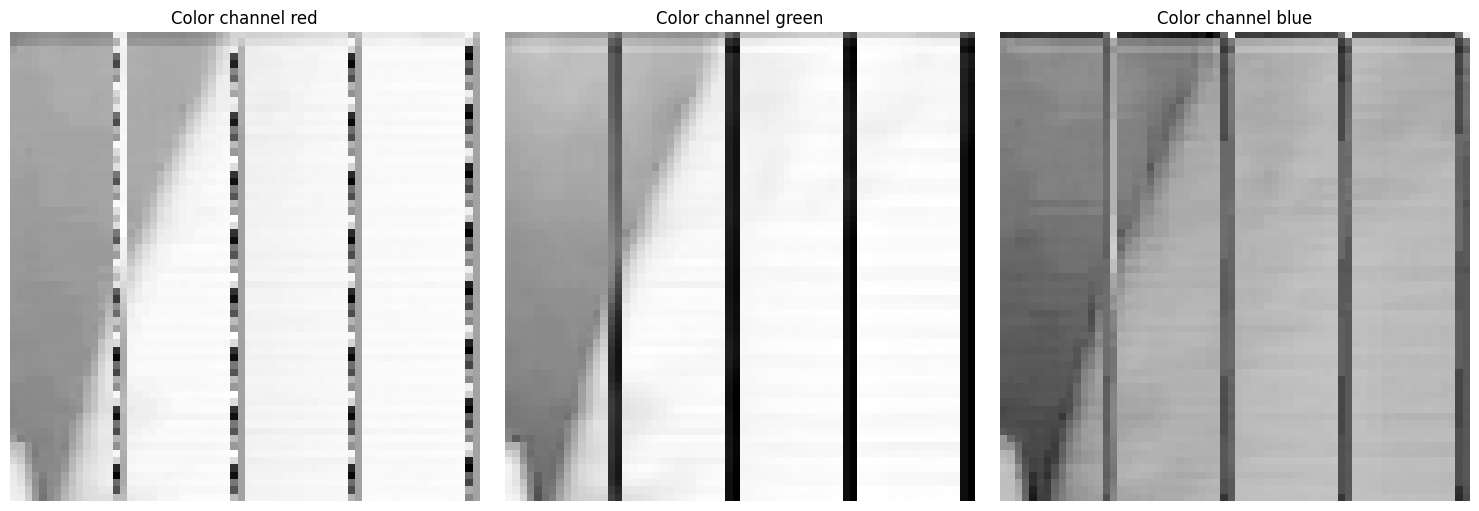

In [71]:
plot_pixel_change_matrix(data_1)
plot_pixel_change_matrix(data_2)
plot_pixel_change_matrix(data_3)

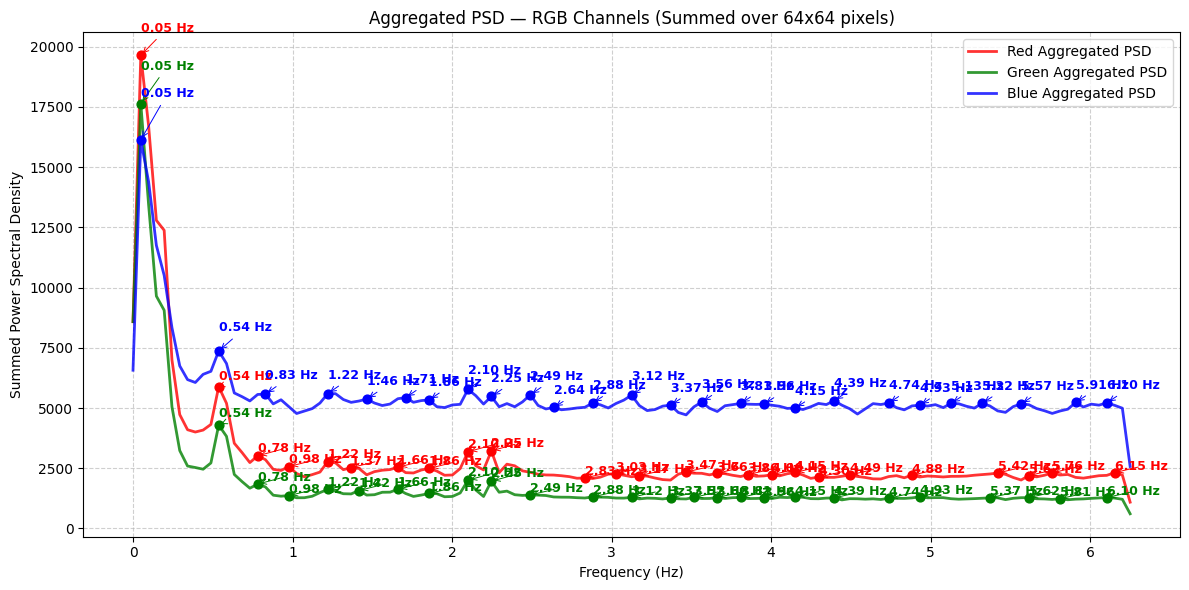

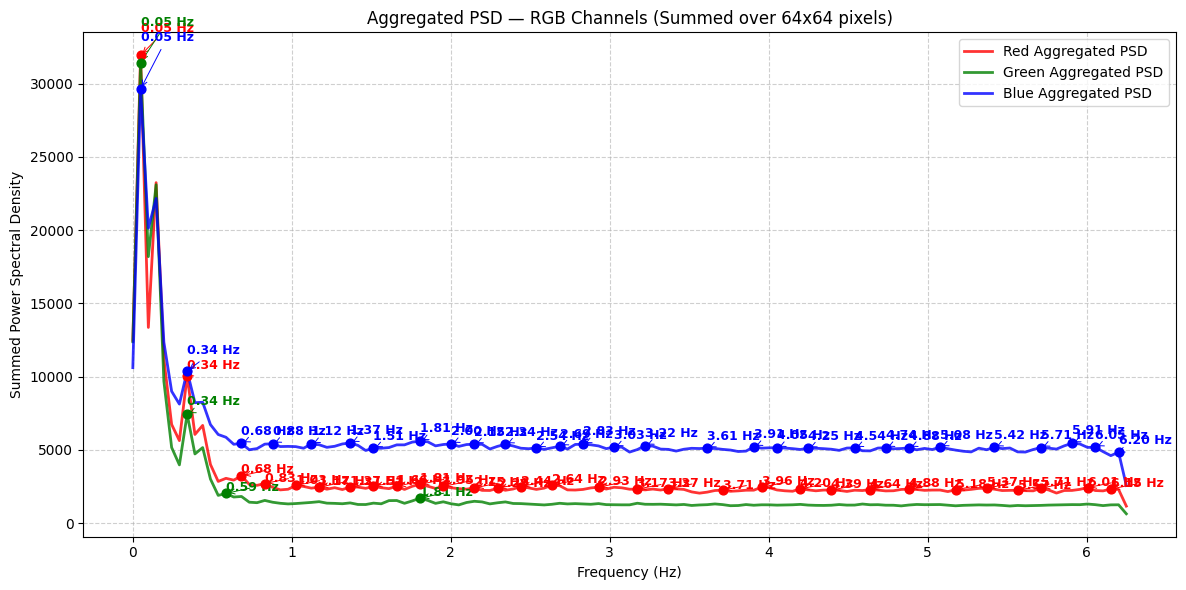

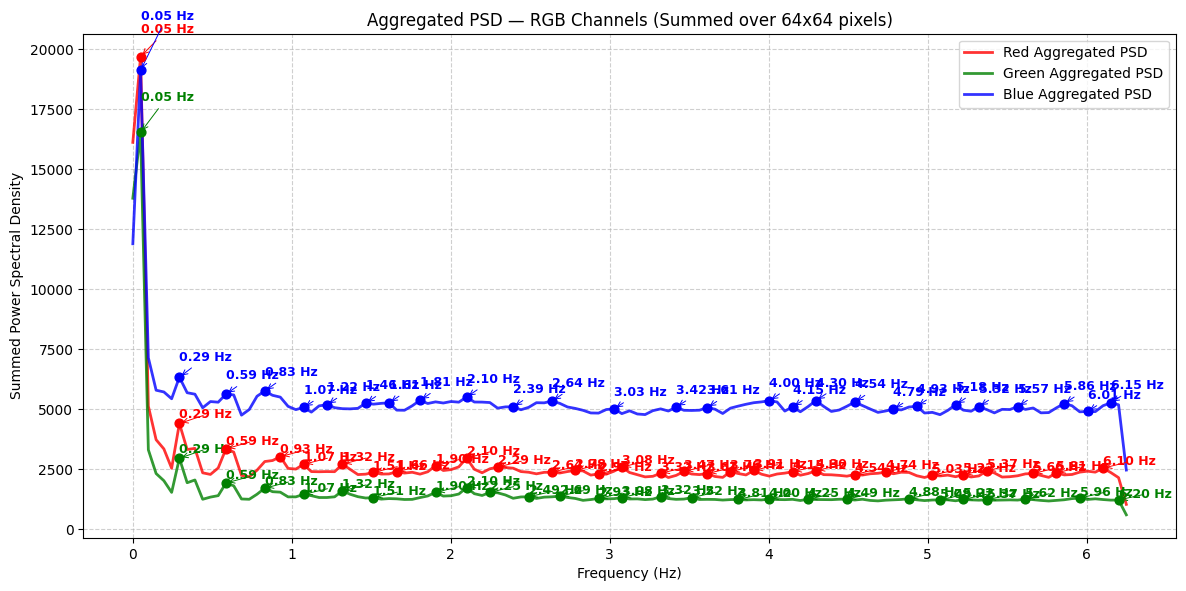

In [72]:
plot_aggregated_psd_rgb(data_1)
plot_aggregated_psd_rgb(data_2)
plot_aggregated_psd_rgb(data_3)

## Hand Data

../04_2_pc_receive/frames_rg_888_64w-64h_20251204_223055.npy shape:(350, 64, 64, 3)


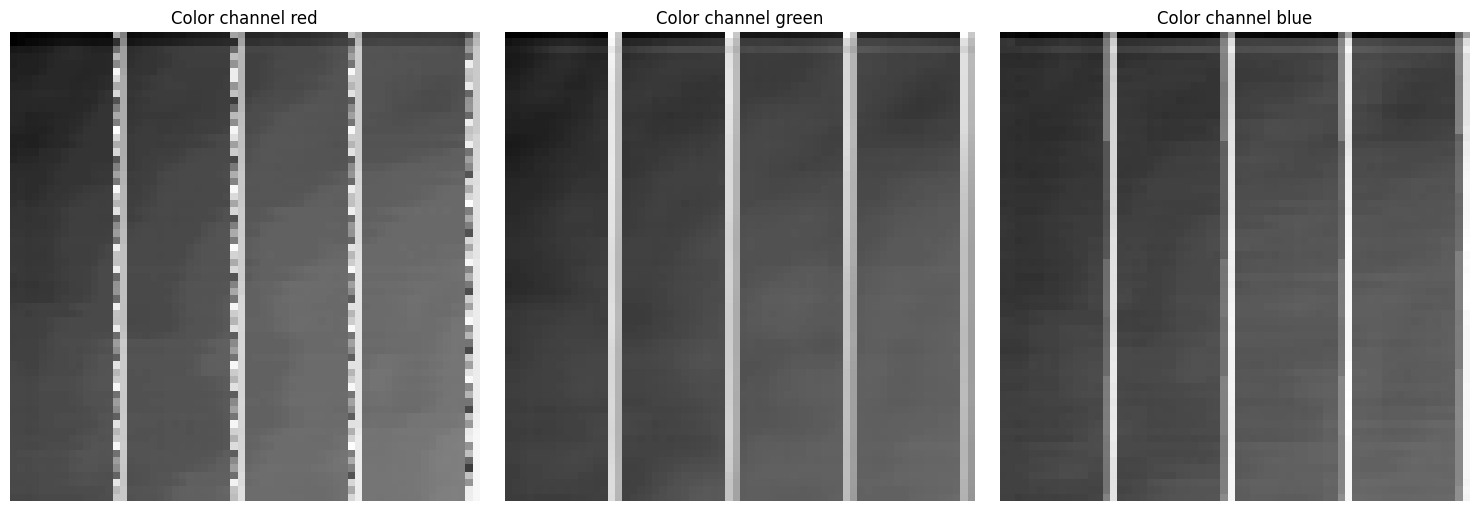

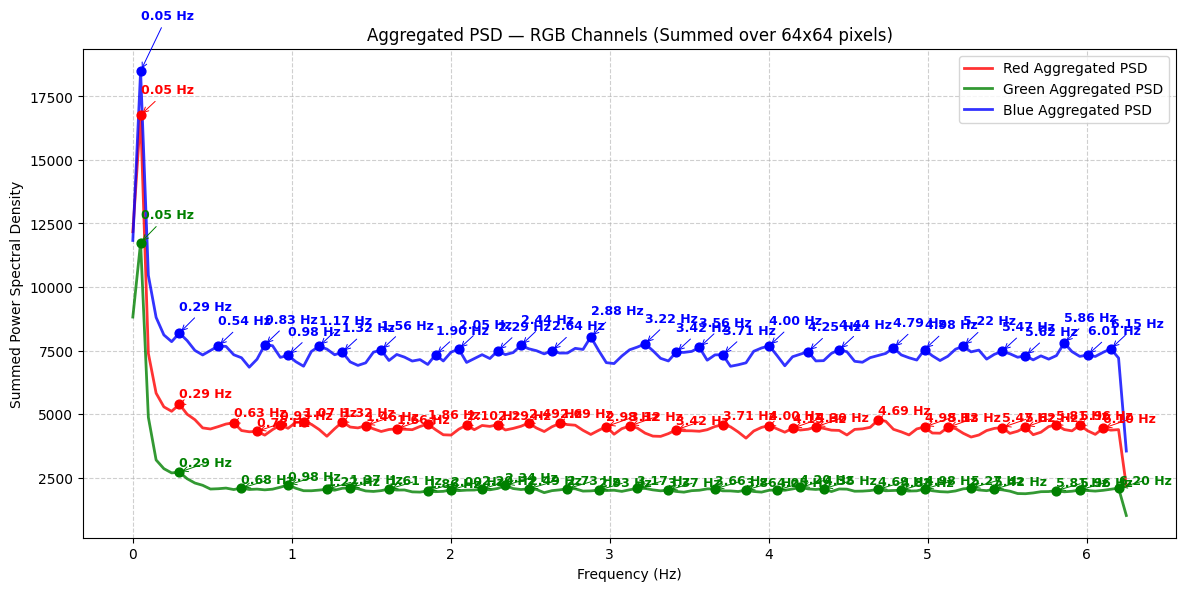

In [73]:
data_1 = load_data("../04_2_pc_receive/frames_rg_888_64w-64h_20251204_223055.npy")
plot_pixel_change_matrix(data_1)
plot_aggregated_psd_rgb(data_1)